### Описание проекта
Интернет-магазин, который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation).  Нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Перед нами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и мы планируем кампанию на 2017-й. Нужно отработать принцип работы с данными. Не важно, прогнозируем ли мы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

### Изучим общую информацию и обработаем данные

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
games = pd.read_csv('/datasets/games.csv')

In [3]:
print(games.head(10))

                        Name Platform  Year_of_Release         Genre  \
0                 Wii Sports      Wii           2006.0        Sports   
1          Super Mario Bros.      NES           1985.0      Platform   
2             Mario Kart Wii      Wii           2008.0        Racing   
3          Wii Sports Resort      Wii           2009.0        Sports   
4   Pokemon Red/Pokemon Blue       GB           1996.0  Role-Playing   
5                     Tetris       GB           1989.0        Puzzle   
6      New Super Mario Bros.       DS           2006.0      Platform   
7                   Wii Play      Wii           2006.0          Misc   
8  New Super Mario Bros. Wii      Wii           2009.0      Platform   
9                  Duck Hunt      NES           1984.0       Shooter   

   NA_sales  EU_sales  JP_sales  Other_sales  Critic_Score User_Score Rating  
0     41.36     28.96      3.77         8.45          76.0          8      E  
1     29.08      3.58      6.81         0.77     

In [4]:
print(games.isnull().sum())

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64


In [5]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


### Подготовим данные:

Приведем название столбцов к нижнему регистру:

In [6]:
games.columns = games.columns.str.lower()

Попробуем разобраться с пропусками, начнем с столбца названия игры, таких пропусков всего два, заменим название этих игр на unknown.

In [7]:
games['name'] = games['name'].fillna('unknown')

Далее посмотрим год выпуска игр, вызовем часть строк с пропущенными значениями с этом столбце:

In [8]:
games.query('year_of_release == "NaN"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16373,PDC World Championship Darts 2008,PSP,NaN,Sports,0.01,0.00,0.00,0.00,43.0,tbd,E10+
16405,Freaky Flyers,GC,NaN,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T
16448,Inversion,PC,NaN,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M
16458,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Заметим, что в некоторых названиях игр указан год. Зачастую производители выпускают игры с опережением, как бы на новый сезон или же тематика игр связана с будущим или прошлым, в 90-х годах могли игру назвать таким образом, что в названии было бы указано 2020 или наоборот . Делаем из этого вывод, что заменить пропуски таким образом нельзя, т.к. исказится представление о данных. Поэтому оставим пропуски, их не очень много по сравнению с общим количеством строк.

Рассмотрим пропуски столбцов critic_score user_score. Пропуски в этих столбцах заменить сложно, потому что нет закономерности по которой бы производилась оценка, все зависит от качества конкретной игры. Единственное, мы можем заменить пропуски на индикаторы, т.е. значения которые невозможны и при анализе, мы их сразу увидим. Заменим пропуски на 0, т.к. в таблице нет таких значений 

In [9]:
print(games.isnull().sum())

name                  0
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64


Проверим на наличие нулевых значений, для замены на индикаторы и заменим пропуски:

In [10]:
games.query('critic_score == 0')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating


In [11]:
games['critic_score'] = games['critic_score'].fillna(0)

In [12]:
games.query('user_score == 0')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating


In [13]:
games['user_score'] = games['user_score'].fillna(0)

Тип данных столбца user_score - object, проверим на уникальные значения:

In [14]:
games['user_score'].unique()

array(['8', 0, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Видим значение tbd, 'To Be Determined', то есть "Будет определено" значит у рейтинга еще не сформирован рейтинг, это эквивалентно пропущенным значениям, заменим tbd на нулевые значения

In [15]:
games['user_score'] = games['user_score'].replace('tbd', 0)

Заменим тип данных на float:

In [16]:
games['user_score'] = games['user_score'].astype('float')

Заменить пропуски в rating тоже очень сложно, если предположить, т.к. игры даже одного жарна, зачастую имеют разные возрастные ограничения. Заменим пропуски на unknown

In [17]:
games['rating'] = games['rating'].fillna('unknown')

### Проведем исследовательский анализ данных:

Посмотрим, сколько игр выпускалось в разные годы:

In [18]:
df = games.groupby('year_of_release')['name'].count()

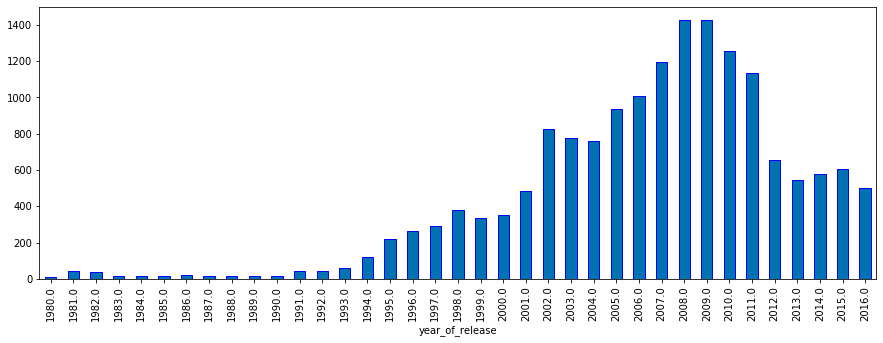

In [19]:
plt.style.use('seaborn-colorblind')
df_years = games.groupby('year_of_release')['name'].count()
plot = df_years.plot(kind='bar', y='name', figsize=(15,5), ec='blue')

### Посмотрим, как менялись продажи по платформам. Выберем платформы с наибольшими суммарными продажами и построим распределение по годам

Создадим столбец с сумарными продажами в трех регионах

In [20]:
games['sales_total'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']

In [21]:
df_platform = games.groupby('platform')['sales_total'].sum().sort_values(ascending=False)

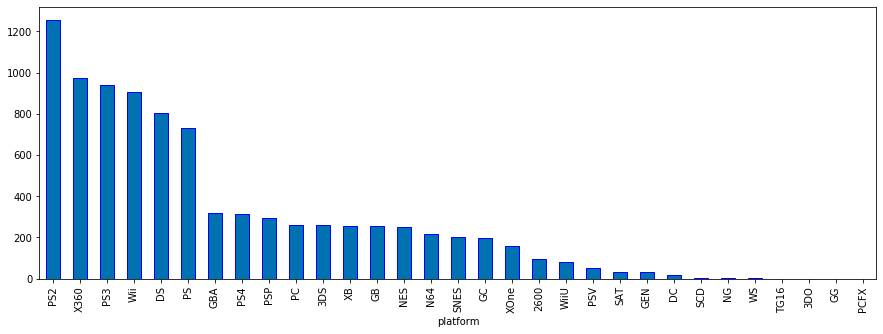

In [22]:
plt.style.use('seaborn-colorblind')
df_platform = games.groupby('platform')['sales_total'].sum().sort_values(ascending=False)
plot = df_platform.plot(kind='bar', y='name', figsize=(15,5), ec='blue')

Исходя из диаграммы, можно сделать вывод, что наибольшей популярностью пользуются 6 платформ, для них и построим распределение по годам:

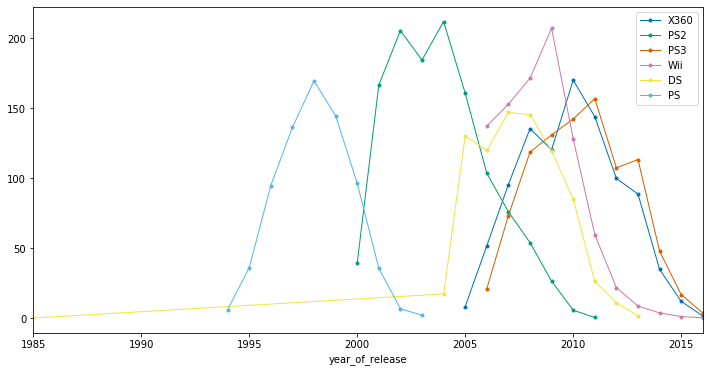

In [23]:
column_list1 = ['X360', 'PS2', 'PS3', 'Wii', 'DS','PS']
for i in column_list1:
    df_1 = games.query('platform == @i')
    df_platform_2 = df_1.groupby('year_of_release')['sales_total'].sum()
    df_platform_2.plot(x='year_of_release', y='sales_total',style='.-', kind='line', label=i, fontsize=10, linewidth=1, figsize=(12,6))
    plt.legend()
    
    

Если смотреть по графику, время 'жизни' платформ составляет приблизительно 10 лет, единстсвенное, что выделяется это данные по платформе DS,старт продаж игр на эту платформу начался аж в далеком 1985 и лишь в 2004 эта платформа начала приобретать популярность, возможно эта игровая приставка получила новое техническое оснащение и начали активно выпускаться игры, при этом оставив название из 1985 года



#### Выберем актуальный период

На мой взгляд, актуальным является период с 2006 по 2016 год, т.к. в этот период имеются данные о продажах по всем самым популярным платформам и мы сможем отследить динамику роста или падения интереса на будущее. Построим график, отображающий динамику продаж по актуальным годам и посмотрим: Какие платформы лидируют по продажам, растут или падают?

In [24]:
games_actual = games.query('year_of_release > 2005')

In [25]:
column_list1 = games_actual['platform'].unique().tolist()
print(column_list1)

['Wii', 'DS', 'X360', 'PS3', 'PS4', '3DS', 'PC', 'XOne', 'WiiU', 'PS2', 'PSP', 'PSV', 'GBA', 'GC', 'XB', 'DC']


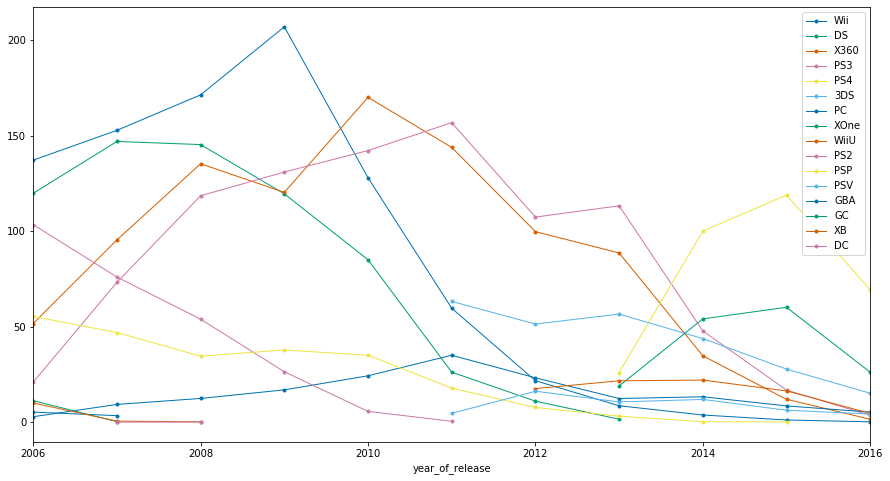

In [26]:
for i in column_list1:
    df_1 = games_actual.query('platform == @i')
    df_platform_2 = df_1.groupby('year_of_release')['sales_total'].sum()
    df_platform_2.plot(x='year_of_release', y='sales_total',style='.-', kind='line', label=i, fontsize=10, linewidth=1, figsize=(15,8))
    plt.legend()
    

In [27]:
games_2015 = games.query('year_of_release > 2015')

In [28]:
games_2015.groupby('platform')['sales_total'].sum().sort_values(ascending=False)

platform
PS4     69.25
XOne    26.15
3DS     15.14
PC       5.25
WiiU     4.60
PSV      4.25
PS3      3.60
X360     1.52
Wii      0.18
Name: sales_total, dtype: float64

В конце 2016 года вперед выравались три платформы: PS4, XOne, 3DS. По графику можно заметить общую тенденцию падения продаж по всем самым популярным платформам, люди меньше стали играть , рынок игр начинает потихоньку падать.



Построим график «ящик с усами» по глобальным продажам каждой игры и разбивкой по платформам: 

Глобальные продажи:

(0, 1.5)

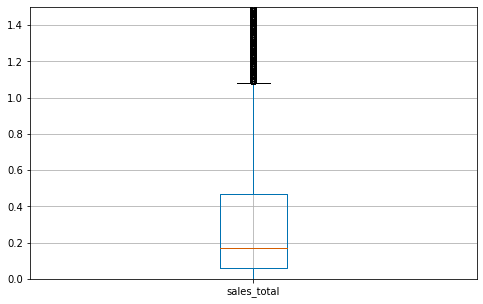

In [29]:
ax = games.boxplot(column='sales_total',fontsize=10, figsize=(8,5))
ax.set_ylim(0, 1.5)

In [30]:
games['sales_total'].describe()

count    16715.000000
mean         0.533396
std          1.548261
min          0.000000
25%          0.060000
50%          0.170000
75%          0.470000
max         82.540000
Name: sales_total, dtype: float64

По платформам:

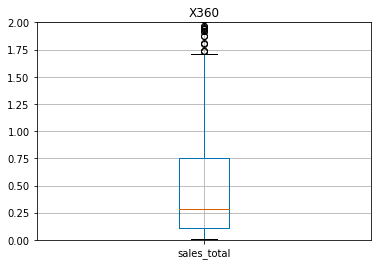

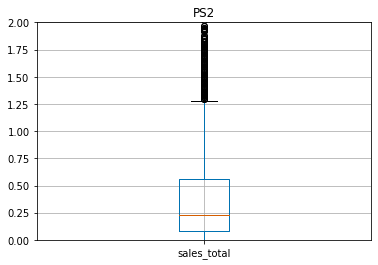

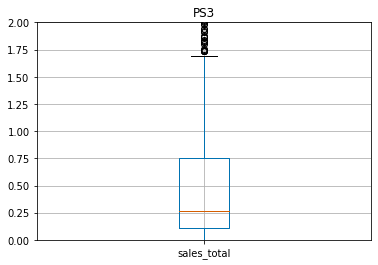

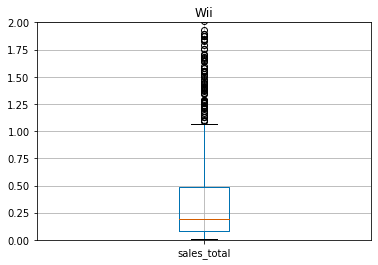

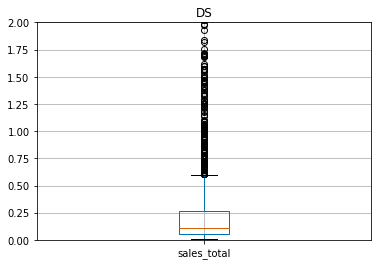

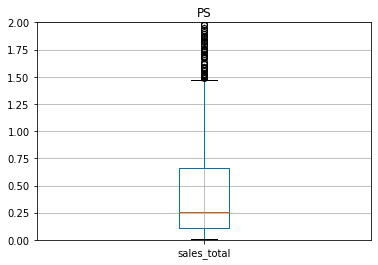

In [31]:
column_list1 = ['X360', 'PS2', 'PS3', 'Wii', 'DS','PS']
for i in column_list1:    
    df_1 = games.query('platform == @i')
    st = df_1.boxplot(column='sales_total')
    st.set_ylim(0, 2)
    st.set_title(i)
    plt.show()
   


In [32]:
column_list1 = ['X360', 'PS2', 'PS3', 'Wii', 'DS','PS']
for i in column_list1:
    
    df_1 = games.query('platform == @i')
    print(i)
    print(df_1['sales_total'].describe())
    print()
    

X360
count    1262.000000
mean        0.769746
std         1.615674
min         0.010000
25%         0.110000
50%         0.280000
75%         0.757500
max        21.820000
Name: sales_total, dtype: float64

PS2
count    2161.000000
mean        0.581106
std         1.137927
min         0.000000
25%         0.080000
50%         0.230000
75%         0.560000
max        20.810000
Name: sales_total, dtype: float64

PS3
count    1331.000000
mean        0.705973
std         1.391749
min         0.000000
25%         0.110000
50%         0.270000
75%         0.750000
max        21.050000
Name: sales_total, dtype: float64

Wii
count    1320.000000
mean        0.687508
std         3.126609
min         0.010000
25%         0.080000
50%         0.190000
75%         0.482500
max        82.540000
Name: sales_total, dtype: float64

DS
count    2151.000000
mean        0.374765
std         1.426451
min         0.010000
25%         0.050000
50%         0.110000
75%         0.270000
max        29.800000


Если смотреть по медиальному значению, то у всех топовых платформ значение варьируется от 0,2 до 0,3 млн долларов за игру, в то время, как у DS этот показатель практически в 2 раза меньше и равен 0,11 , так же обстоят дела и с другими показателями по сравнению с конкурентами. Если же сравнивать с данными по глобальным продажа, то показали лидеров рейтинга куда выше, это говорит, а существееном доминировании нескольких платформ.

Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами. 

In [33]:
df_x360 = games.query('platform == "X360" and critic_score != 0 and user_score != 0')

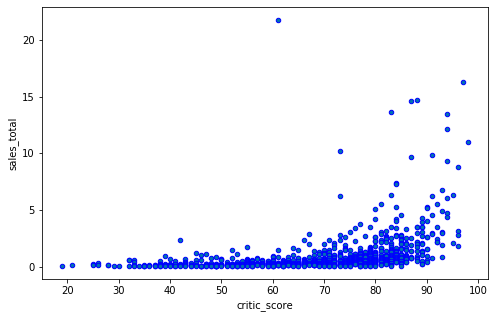

In [34]:
df_x360.plot(x='critic_score', y='sales_total',ec='blue', kind='scatter', figsize=(8,5))

Заметим, что с увеличением рейтинга критиков увеличивается и уровень выручки с продажи игр, что соответствует логике, ведь чем лучше и качественнее сделана игра, тем больше денег она принесет 

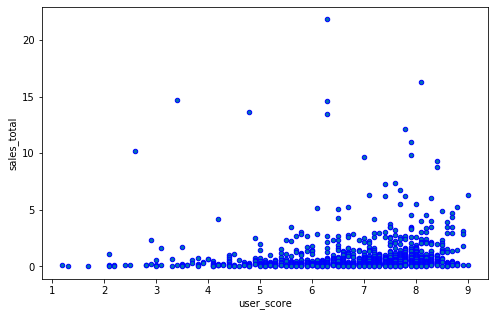

In [35]:
df_x360.plot(x='user_score', y='sales_total', ec='blue', figsize=(8,5), kind='scatter')

С рейнгом пользователей дела обстоят также, чем лучше отзывы, тем больше прибыли, но тут больше выбивающихся значений, т.к. зачастую пользователи не объективны в высказывании мнения об играх и могут ставить эти оценки под влиянием эмоций, что-то не загрузилось, где-то затормозила случайно игра, может железо не тянет, сразу писать негативный отзыв.

Посчитаем корреляцию между отзывами и продажами:

Глобальные продажи:

In [36]:
df_x360['user_score'].corr(df_x360['sales_total'])

0.1104115038347283

In [37]:
df_x360['critic_score'].corr(df_x360['sales_total'])

0.38951312357066675

Сильнее всего на конечную стоимость влияет оценка критиков.  Практически не влияет - оценка пользователей.

По платформам:

In [38]:
df_corr = games.query('critic_score != 0 and user_score != 0')

In [39]:
column_list1 = ['X360', 'PS2', 'PS3', 'Wii', 'DS','PS','PS4','XOne']
for i in column_list1:    
    df_corr_new = df_corr.query('platform == @i')
    cs = df_corr_new['user_score'].corr(df_corr_new['sales_total'])
    us = df_corr_new['critic_score'].corr(df_corr_new['sales_total'])
    print('Платформа:', i)
    print('Корреляции между critical_score и sales_total:', cs.round(2))
    print('Корреляции между user_score и sales_total:', us.round(2))
    
    print()

Платформа: X360
Корреляции между critical_score и sales_total: 0.11
Корреляции между user_score и sales_total: 0.39

Платформа: PS2
Корреляции между critical_score и sales_total: 0.17
Корреляции между user_score и sales_total: 0.39

Платформа: PS3
Корреляции между critical_score и sales_total: 0.14
Корреляции между user_score и sales_total: 0.43

Платформа: Wii
Корреляции между critical_score и sales_total: 0.11
Корреляции между user_score и sales_total: 0.17

Платформа: DS
Корреляции между critical_score и sales_total: 0.14
Корреляции между user_score и sales_total: 0.23

Платформа: PS
Корреляции между critical_score и sales_total: 0.3
Корреляции между user_score и sales_total: 0.43

Платформа: PS4
Корреляции между critical_score и sales_total: -0.03
Корреляции между user_score и sales_total: 0.41

Платформа: XOne
Корреляции между critical_score и sales_total: -0.09
Корреляции между user_score и sales_total: 0.41



Данные  платформам X360, PS2, PS3, PS похожи с данными по глобальным продажам, когда как для DS и Wii имеют меньшую зависимость продаж от рейтингов критиков и пользователей. Если смотреть на XOne и PS4 , то рейтинги пользователей и продажи имеют отрицательную корреляцию, возможно это новые платформы и продукты на них выходят еще сырые, игры покупаются из-за интереса, а потом пользователям просто не заходит игра и они ставят заниженный рейтинг.


#### Посмотрим на общее распределение игр по жанрам

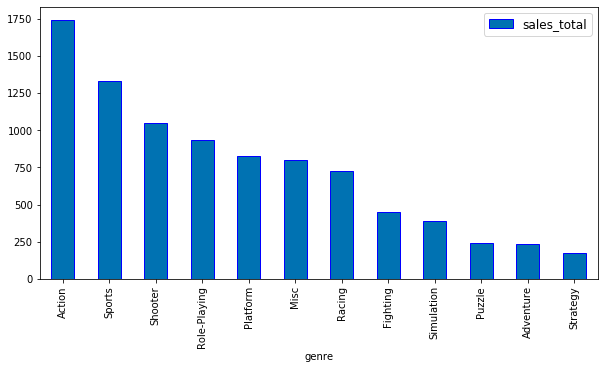

In [40]:
plt.style.use('seaborn-colorblind')
df_genre = games.groupby('genre')['sales_total'].sum().sort_values(ascending=False)
plot = df_genre.plot(kind='bar', y='sales_total', figsize=(10,5), ec='blue')
plot.legend(prop={'size':12})

In [41]:
df_genre = games.groupby('genre')['sales_total'].sum().sort_values(ascending=False)
print(df_genre)

genre
Action          1744.17
Sports          1331.27
Shooter         1052.45
Role-Playing     934.56
Platform         827.77
Misc             802.51
Racing           728.67
Fighting         447.53
Simulation       389.97
Puzzle           242.57
Adventure        237.59
Strategy         174.23
Name: sales_total, dtype: float64


Топ-3 самых прибыльных жанров: Action Sports Shooter. Возможно, самые топовые компании c большой аудиторей и высоким качеством ожидаемых игр, как раз специализируются на этих 3 жанрах. Самые не популярные жанры: strategy, adventure, puzzle.



### Составим портрет пользователя каждого региона

Топ-5 платформ:

In [42]:
def platform(region, ax):
    
    
    plt.style.use('seaborn-colorblind') 
    df_platform_na = games.groupby('platform')[region].sum().sort_values(ascending=False)[:5]
    plot = df_platform_na.plot(kind='bar', y=i, ax=axes[ax], ec='blue', label=region, fontsize=15)
    plot.legend(prop={'size':14})
        
    

    

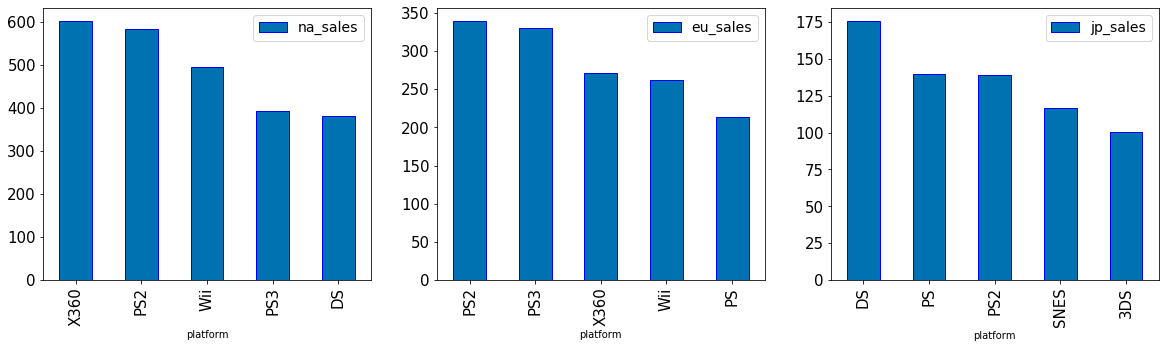

In [43]:
fig, axes = plt.subplots(1, 3, figsize=(20,5))
platform('na_sales', 0)
platform('eu_sales', 1)
platform('jp_sales', 2)

В Северной Америке имеют большую популярность приставки  X360 и PS2. Немного отстает Wii PS3 и DS 

В Европе популярны PS2 и PS3. За ними X360, Wii и PS.

В Японии топ-1 - DS. За ними  PS и PS2. И дальше SNES и 3DS.

Топ-5 жанров:

In [44]:
def genre(region, ax):
    
    
    plt.style.use('seaborn-colorblind') 
    df_platform_na = games.groupby('genre')[region].sum().sort_values(ascending=False)[:5]
    plot = df_platform_na.plot(kind='bar', y=i, ax=axes[ax], ec='blue', label=region, fontsize=15)
    plot.legend(prop={'size':14})
        

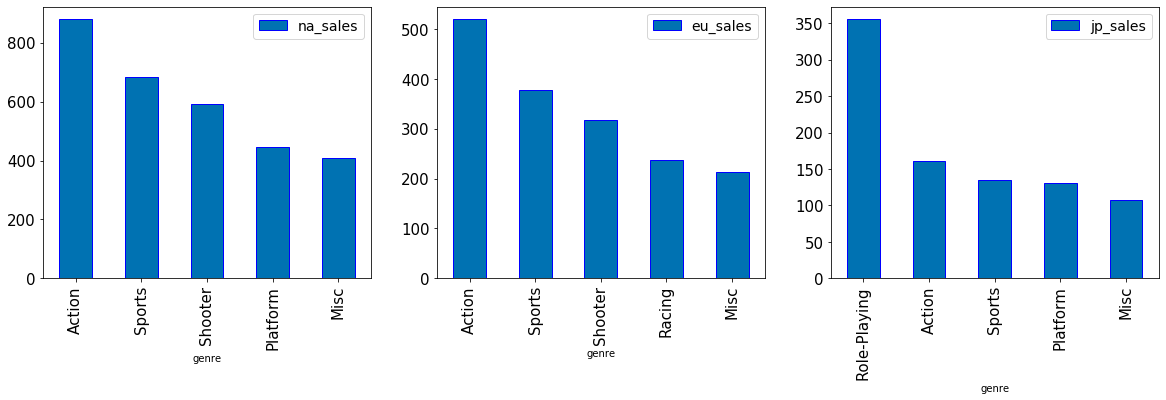

In [45]:
fig, axes = plt.subplots(1, 3, figsize=(20,5))
genre('na_sales', 0)
genre('eu_sales', 1)
genre('jp_sales', 2)

В Северной Америке и Европе ситуация примерно похожая лидирующие позиции занимают такие жанры: экшн, спортивные игры и шутеры. Далее вкусы начинают различаться в Северной Америке Топ-4 занимают платформеры, в то время, как в Европе любят поиграть в гонки.
В Японии на первом месте ролевые игры. Далее экшны и спортивные игры. Японские предпочтения всегда отличаются от остального мира.

Рейтинг:

In [46]:
games['rating'].value_counts()

unknown    6766
E          3990
T          2961
M          1563
E10+       1420
EC            8
RP            3
K-A           3
AO            1
Name: rating, dtype: int64

In [47]:
df_rating = games.query('rating != "unknown"')



In [48]:
def rating(region, ax):
     
    plt.style.use('seaborn-colorblind') 
    df_platform_na = df_rating.groupby('rating')[region].sum().sort_values(ascending=False)[:4]
    plot = df_platform_na.plot(kind='bar', y=i, ax=axes[ax], ec='blue', label=region, fontsize=15)
    plot.legend(prop={'size':14})

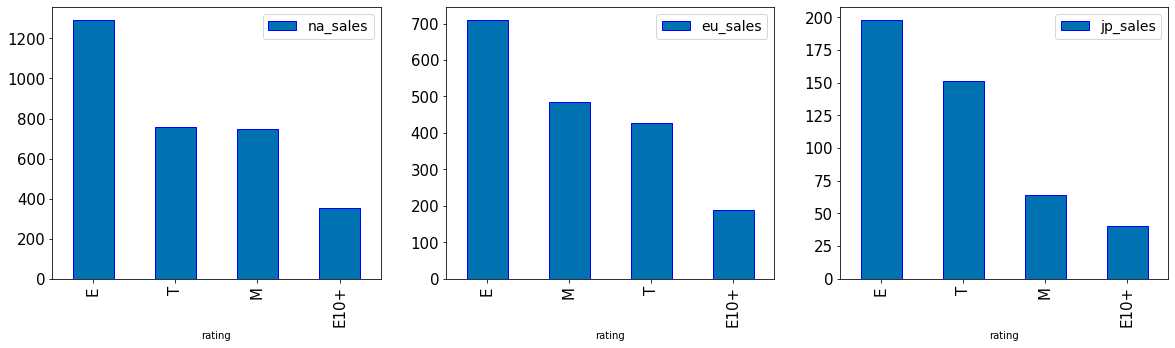

In [49]:
fig, axes = plt.subplots(1, 3, figsize=(20,5))
rating('na_sales', 0)
rating('eu_sales', 1)
rating('jp_sales', 2)

Большая часть прибыли получают производители игр из категории E, т.е без ограничения возраста и так по всему миру, это логично, т.к. этот рейтинг охватывает всю аудиторию, потому что нет ограничений. Если смотреть на Северную Америку и Европу, то 2 места занимают игры T, охват аудитории 17+, но думаю в нее них играют кто попало и дети и взрослые, а т.к. Япония такая страна, люди всегда там страются соблюдать правила, то поэтому и игры 17+ имеют меньшую популярность, просто не разрешают играть детям и на второе место вырываются игры с рейтингом Т(13-19). 


Проверим гипотезы:

Средние пользовательские рейтинги платформ Xbox One и PC одинаковые:

Н0 (нулевая гипотеза) - средние пользовательские рейтинги платформ Xbox One и PC одинаковые.
Н1 (альтернативная гипотеза) - средние пользовательские рейтинги платформ Xbox One и PC отличаются .

In [50]:
games_1 = games.query('user_score != 0')

In [51]:
rating_pc = games_1[(games_1['platform'] == 'PC')]['user_score']

In [52]:
rating_xone = games_1[(games_1['platform'] == 'XOne')]['user_score']

In [53]:
rating_pc.mean()

7.062467532467533

In [54]:
rating_xone.mean()

6.521428571428572

In [60]:
alpha = .05
results = st.ttest_ind(
    rating_pc, 
    rating_xone)

In [61]:
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.3896435533548819e-05
Отвергаем нулевую гипотезу


Вывод: отвергаем нулевую гипотезу. Cредние пользовательские рейтинги платформ Xbox One и PC отличаются 

Средние пользовательские рейтинги жанров Action (англ. «действие») и Sports (англ. «виды спорта») разные:

Н0 (нулевая гипотеза) - средние пользовательские рейтинги жанров Action и Sports одинаковые.

Н1 (альтернативная гипотеза) - средние пользовательские рейтинги жанров Action и Sports отличаются.

In [62]:
rating_action = games_1[(games_1['genre'] == 'Action')]['user_score']

In [63]:
rating_sports = games_1[(games_1['genre'] == 'Sports')]['user_score']

In [64]:
alpha = .05
results = st.ttest_ind(
    rating_action, 
    rating_sports)

In [65]:
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.10406951359049141
Не получилось отвергнуть нулевую гипотезу


Вывод: Не получилось отвергнуть нулевую гипотезу. Средние пользовательские рейтинги жанров Action (англ. «действие») и Sports (англ. «виды спорта») одинаковые.



### Общий вывод:

Если смотреть на общую тенденцию по самым популярным платформам, то дела у игрового рынка обстоят не очень хорошо, на данный момент, чтобы играть нужно быть привязанным к месту, а в суровых реалиях современного мира, люди все время куда-то спешат, поэтому на смену приходит мобильный игровой рынок. Если смотреть на факторы, которые влияют на прибыль это конечно же рейтинги, сейчас, что все делают, прежде чем что-то купить, заходят в начинают читать отзывы, искать различные рейтинги, и как мы выяснили, отзывы критиков имеют большее влияние нежели общественное мнение. Так же влияют и предпочтения по жанрам, но тут нужно корректировать в зависимости от региона, так как предпочтения, как оказывается в разных странах разные. Возрастные ограничения, хоть на них и никто не смотрит, в итоге тоже вносят свои 5 копеек, создаешь игру, так создавай для всех, получишь больше прибыли.

